In [1]:
!pip install matplotlib

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch,torchvision
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms

In [3]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)
#data=data*0.5+0.5

data_target=trainset.targets.to(dtype=torch.float32)
#data_target
data=data.view(60000,1,28,28)
data=data.to(dtype=torch.float32)
#data_target=data_target.view(60000,1,28,28)

trainset=TensorDataset(data,data)
trainloader=DataLoader(trainset,batch_size=128,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 57710298.90it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38431374.94it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 84952418.00it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21998301.12it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [4]:
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.to(Device)
    self.noise=torch.rand(25)
    x=28
    self.gen=nn.Sequential(
        nn.ConvTranspose2d(25,x*4,4,1,0),
        nn.BatchNorm2d(x*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(x*4,x*2,4,2,1),
        nn.BatchNorm2d(x*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(x*2,x*1,4,2,1),
        nn.BatchNorm2d(x),
        nn.ReLU(True),

        nn.ConvTranspose2d(x,1,4,2,3),
        nn.Tanh()

    )


  def forward(self,b):
    x=torch.randn(b,25,1,1).to(Device)
    x=self.gen(x)
    return x

'''gen=Generator().to(Device)
y=gen(2)
y.shape,y'''

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.to(Device)
    x=28
    self.disc=nn.Sequential(
            nn.Conv2d(1, 28, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(28) x 32 x 32``
            nn.Conv2d(28, 28 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(28*2) x 16 x 16``
            nn.Conv2d(28 * 2, 28 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(28 * 4, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
    )

  def forward(self,x):
    x=self.disc(x)
    x=x.flatten()
    return x

'''disc=Discriminator().to(Device)
y.shape,disc(y)
'''


In [9]:
epochs=100
gen=Generator().to(Device)
disc=Discriminator().to(Device)
optimizer=optim.Adam(gen.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizer2=optim.Adam(disc.parameters(),lr=0.0002,betas=(0.5,0.999))
criterion=nn.BCELoss()


In [10]:
for epoch in range(epochs):
  disc_loss=0
  gen_loss=0
  count=0
  for input,_ in trainloader:
    input=input.to(Device)
    b,z,c,c=input.shape

    optimizer2.zero_grad()

    real_label=torch.ones(b).to(Device)
    real_out=disc(input)
    loss_d_real=criterion(real_out,real_label)
    #loss_d_real.backward()

    fake_label=torch.zeros(b).to(Device)
    fake_input=gen(b)
    fake_out=disc(fake_input)
    loss_d_fake=criterion(fake_out,fake_label)
    #loss_d_fake.backward()
    loss1=(loss_d_real+loss_d_fake)/2

    disc_loss+=loss_d_real+loss_d_fake
    loss1.backward()
    optimizer2.step()



    optimizer.zero_grad()
    y=gen(b)
    label=torch.ones(b).to(Device)
    gen_out=disc(y)
    loss_gen=criterion(gen_out,label)
    gen_loss+=loss_gen.item()
    #print(loss_gen)
    #print(real_label,fake_label,label,real_out,fake_out,gen_out)

    loss_gen.backward()
    optimizer.step()

    count+=1


  print(f'epoch={epoch},total_gen_loss={gen_loss},total_disc_loss={disc_loss},mean_gen_loss={gen_loss/count},mean_disc_loss={disc_loss/count}')



epoch=0,total_gen_loss=1571.6644922196865,total_disc_loss=162.12069702148438,mean_gen_loss=3.3510969983362187,mean_disc_loss=0.345673143863678
epoch=1,total_gen_loss=866.0487226545811,total_disc_loss=286.6597595214844,mean_gen_loss=1.846585762589725,mean_disc_loss=0.6112148761749268
epoch=2,total_gen_loss=823.698172390461,total_disc_loss=304.54522705078125,mean_gen_loss=1.7562860818559936,mean_disc_loss=0.6493501663208008
epoch=3,total_gen_loss=811.350471675396,total_disc_loss=309.1212158203125,mean_gen_loss=1.729958361781228,mean_disc_loss=0.6591070890426636
epoch=4,total_gen_loss=800.5626600682735,total_disc_loss=317.6734313964844,mean_gen_loss=1.7069566312756366,mean_disc_loss=0.6773421168327332
epoch=5,total_gen_loss=799.5112158954144,total_disc_loss=318.5142517089844,mean_gen_loss=1.7047147460456595,mean_disc_loss=0.6791349053382874


KeyboardInterrupt: 

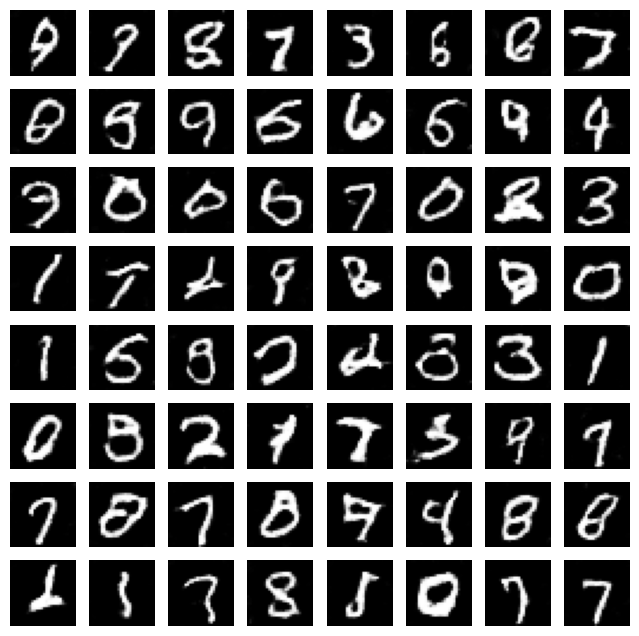

In [13]:
with torch.no_grad():
  #gen.eval()
  z=gen(128)
  z=z[:64]
  x = z.view(8, 8, 28, 28)
  x = x.to('cpu')
  image_np = x.numpy()

  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels
  plt.savefig("sample.jpeg")
  plt.show()